In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_1 = pd.read_csv('ACT1_train_50_corr_red.csv')

In [3]:
train_1.head(5)

,Unnamed: 0,Act,D_1114,D_1115,D_1116,D_1117,D_1215,D_1217,D_1286,D_1486,...,D_519,D_520,D_521,D_5523,D_5524,D_5526,D_5527,D_7349,D_834,D_835
0,0,6.0179,0,0,0,0,5,4,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,4.3003,0,0,0,0,3,2,0,0,...,0,0,0,1,1,0,1,0,0,0
2,2,5.2697,0,0,0,0,3,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,6.1797,0,0,0,0,5,5,0,0,...,0,0,0,4,4,2,3,1,0,0
4,4,4.3003,0,0,0,0,4,2,3,0,...,0,0,0,3,0,0,0,2,0,0


In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
y = train_1['Act'].values
train_1 = train_1.drop(['Act', 'Unnamed: 0'], axis = 1)
x = train_1.values
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=0)


In [5]:
print(np.shape(Y_train), np.shape(X_train), np.shape(Y_test), np.shape(X_test))
Y_train = np.reshape(Y_train,(len(Y_train),1))
Y_test = np.reshape(Y_test,(len(Y_test),1))


(22344,) (22344, 49) (7449,) (7449, 49)


In [6]:
def r_square(X, Y):
    """ r^2 value defined by the competition host, r^2 = 1 indicates 100% prediction accuracy
    """
    avx = np.mean(X)
    avy = np.mean(Y)
    sum1, sumx, sumy = 0, 0, 0
    for i in range(len(X)):
        sum1 += (X[i] - avx)*(Y[i] - avy)
        sumx += (X[i] - avx)*(X[i] - avx)
        sumy += (Y[i] - avy)*(Y[i] - avy)
    print(len(X), sum1, sumx, sumy)
    return sum1*sum1/(sumx*sumy)

In [7]:
from keras import backend as K
#Keras R_2 function
R_2 = []
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

Using TensorFlow backend.


In [8]:
#Keras MAPE function
MAPE = []
def mean_ape(y_true, y_pred):
    return K.mean(K.abs((y_true-y_pred)/y_true))*100

In [9]:
from tensorflow.keras.models import Sequential
import keras
model = Sequential()

In [13]:
#Keras model
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam 
for epochs in [300]: 
    for batch in [50]:
        K.clear_session()
        model = keras.models.Sequential();
        model.add(keras.layers.core.Dense(units = 40, activation='relu', input_dim = 49));
        model.add(keras.layers.core.Dense(units=20, activation = 'relu'))
        model.add(keras.layers.core.Dense(1, activation = 'relu'));
        adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False);
        model.compile(loss="mean_squared_error", optimizer=adam, metrics = [coeff_determination, mean_ape,'mae']);
        print(model.summary(), 'Epochs = ', epochs, 'Batch =', batch);
        history = model.fit(X_train, Y_train, epochs = epochs, batch_size= batch, verbose = 1);
        #print(model.evaluate(X_val, Y_val,verbose=False)[1], )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                2000      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 2,841
Trainable params: 2,841
Non-trainable params: 0
_________________________________________________________________
None Epochs =  300 Batch = 50
Epoch 1/300
22344/22344 [==============================] - 1s 29us/step - loss: 2.5560 - coeff_determination: -6.3588 - mean_ape: 23.8627 - mean_absolute_error: 1.1226
Epoch 2/300
22344/22344 [==============================] - 0s 21us/step - loss: 0.5899 - coeff_determination: -0.5943 - mean_ape: 12.2851 - mean_absolute_error: 0.5888
Epoch 3/300
22344/22344 [=============

22344/22344 [==============================] - 0s 19us/step - loss: 0.1904 - coeff_determination: 0.4954 - mean_ape: 6.3290 - mean_absolute_error: 0.3103
Epoch 46/300
22344/22344 [==============================] - 0s 19us/step - loss: 0.1884 - coeff_determination: 0.4962 - mean_ape: 6.3051 - mean_absolute_error: 0.3089
Epoch 47/300
22344/22344 [==============================] - 0s 17us/step - loss: 0.1877 - coeff_determination: 0.5019 - mean_ape: 6.2968 - mean_absolute_error: 0.3086
Epoch 48/300
22344/22344 [==============================] - 0s 19us/step - loss: 0.1861 - coeff_determination: 0.5031 - mean_ape: 6.2251 - mean_absolute_error: 0.3055
Epoch 49/300
22344/22344 [==============================] - 0s 17us/step - loss: 0.1874 - coeff_determination: 0.5040 - mean_ape: 6.2792 - mean_absolute_error: 0.3078
Epoch 50/300
22344/22344 [==============================] - 0s 20us/step - loss: 0.1855 - coeff_determination: 0.5020 - mean_ape: 6.2298 - mean_absolute_error: 0.3053
Epoch 51/30

22344/22344 [==============================] - 0s 19us/step - loss: 0.1682 - coeff_determination: 0.5446 - mean_ape: 5.8906 - mean_absolute_error: 0.2888
Epoch 95/300
22344/22344 [==============================] - 0s 18us/step - loss: 0.1672 - coeff_determination: 0.5527 - mean_ape: 5.8941 - mean_absolute_error: 0.2888
Epoch 96/300
22344/22344 [==============================] - 0s 17us/step - loss: 0.1678 - coeff_determination: 0.5470 - mean_ape: 5.8927 - mean_absolute_error: 0.2887
Epoch 97/300
22344/22344 [==============================] - 0s 18us/step - loss: 0.1664 - coeff_determination: 0.5509 - mean_ape: 5.8735 - mean_absolute_error: 0.2876
Epoch 98/300
22344/22344 [==============================] - 0s 18us/step - loss: 0.1668 - coeff_determination: 0.5490 - mean_ape: 5.9011 - mean_absolute_error: 0.2888
Epoch 99/300
22344/22344 [==============================] - 0s 18us/step - loss: 0.1668 - coeff_determination: 0.5494 - mean_ape: 5.8640 - mean_absolute_error: 0.2874
Epoch 100/3

22344/22344 [==============================] - 0s 22us/step - loss: 0.1583 - coeff_determination: 0.5700 - mean_ape: 5.7247 - mean_absolute_error: 0.2800
Epoch 143/300
22344/22344 [==============================] - 1s 23us/step - loss: 0.1597 - coeff_determination: 0.5763 - mean_ape: 5.7473 - mean_absolute_error: 0.2812
Epoch 144/300
22344/22344 [==============================] - 1s 27us/step - loss: 0.1589 - coeff_determination: 0.5730 - mean_ape: 5.7386 - mean_absolute_error: 0.2807
Epoch 145/300
22344/22344 [==============================] - 0s 21us/step - loss: 0.1576 - coeff_determination: 0.5766 - mean_ape: 5.6942 - mean_absolute_error: 0.2787
Epoch 146/300
22344/22344 [==============================] - 0s 20us/step - loss: 0.1578 - coeff_determination: 0.5721 - mean_ape: 5.7083 - mean_absolute_error: 0.2793
Epoch 147/300
22344/22344 [==============================] - 0s 20us/step - loss: 0.1573 - coeff_determination: 0.5757 - mean_ape: 5.7053 - mean_absolute_error: 0.2793
Epoch 

22344/22344 [==============================] - 1s 22us/step - loss: 0.1532 - coeff_determination: 0.5882 - mean_ape: 5.6208 - mean_absolute_error: 0.2749
Epoch 190/300
22344/22344 [==============================] - 0s 21us/step - loss: 0.1529 - coeff_determination: 0.5843 - mean_ape: 5.6266 - mean_absolute_error: 0.2752
Epoch 191/300
22344/22344 [==============================] - 0s 17us/step - loss: 0.1521 - coeff_determination: 0.5932 - mean_ape: 5.6097 - mean_absolute_error: 0.2743
Epoch 192/300
22344/22344 [==============================] - 0s 17us/step - loss: 0.1526 - coeff_determination: 0.5914 - mean_ape: 5.6257 - mean_absolute_error: 0.2753
Epoch 193/300
22344/22344 [==============================] - 0s 21us/step - loss: 0.1542 - coeff_determination: 0.5795 - mean_ape: 5.6940 - mean_absolute_error: 0.2782
Epoch 194/300
22344/22344 [==============================] - 0s 18us/step - loss: 0.1523 - coeff_determination: 0.5929 - mean_ape: 5.6169 - mean_absolute_error: 0.2747
Epoch 

22344/22344 [==============================] - 0s 18us/step - loss: 0.1495 - coeff_determination: 0.5992 - mean_ape: 5.5948 - mean_absolute_error: 0.2733
Epoch 237/300
22344/22344 [==============================] - 0s 18us/step - loss: 0.1499 - coeff_determination: 0.5951 - mean_ape: 5.5839 - mean_absolute_error: 0.2728
Epoch 238/300
22344/22344 [==============================] - 0s 17us/step - loss: 0.1492 - coeff_determination: 0.5970 - mean_ape: 5.5465 - mean_absolute_error: 0.2711
Epoch 239/300
22344/22344 [==============================] - 0s 18us/step - loss: 0.1489 - coeff_determination: 0.6005 - mean_ape: 5.5641 - mean_absolute_error: 0.2720
Epoch 240/300
22344/22344 [==============================] - 0s 18us/step - loss: 0.1487 - coeff_determination: 0.5964 - mean_ape: 5.5510 - mean_absolute_error: 0.2714
Epoch 241/300
22344/22344 [==============================] - 0s 18us/step - loss: 0.1493 - coeff_determination: 0.5989 - mean_ape: 5.5629 - mean_absolute_error: 0.2719
Epoch 

22344/22344 [==============================] - 0s 18us/step - loss: 0.1461 - coeff_determination: 0.6028 - mean_ape: 5.4984 - mean_absolute_error: 0.2688
Epoch 285/300
22344/22344 [==============================] - 0s 17us/step - loss: 0.1477 - coeff_determination: 0.6014 - mean_ape: 5.5269 - mean_absolute_error: 0.2702
Epoch 286/300
22344/22344 [==============================] - 0s 17us/step - loss: 0.1455 - coeff_determination: 0.6015 - mean_ape: 5.4888 - mean_absolute_error: 0.2680
Epoch 287/300
22344/22344 [==============================] - 0s 17us/step - loss: 0.1466 - coeff_determination: 0.6092 - mean_ape: 5.5075 - mean_absolute_error: 0.2690
Epoch 288/300
22344/22344 [==============================] - 0s 17us/step - loss: 0.1465 - coeff_determination: 0.6050 - mean_ape: 5.5295 - mean_absolute_error: 0.2700
Epoch 289/300
22344/22344 [==============================] - 0s 17us/step - loss: 0.1462 - coeff_determination: 0.6019 - mean_ape: 5.5068 - mean_absolute_error: 0.2690
Epoch 

In [14]:
print(history.history.keys())

dict_keys(['loss', 'coeff_determination', 'mean_ape', 'mean_absolute_error'])


In [16]:
print(model.evaluate(X_val, Y_val,verbose=False)[2])
print(model.evaluate(X_test, Y_test,verbose=False)[2])

6.4219149575197605
6.420190749512149


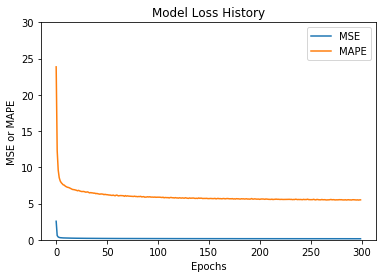

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['mean_ape'])
plt.title('Model Loss History')
plt.ylim(0,30)
plt.ylabel('MSE or MAPE')
plt.xlabel('Epochs')
plt.legend(['MSE', 'MAPE'])
